In [272]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [273]:


df = pd.read_csv('C:/WISDM.csv', index_col=0)
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan
df.head()

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [274]:
df.isnull().sum()

user-id      0
activity     0
timestamp    0
X            0
Y            0
Z            0
dtype: int64

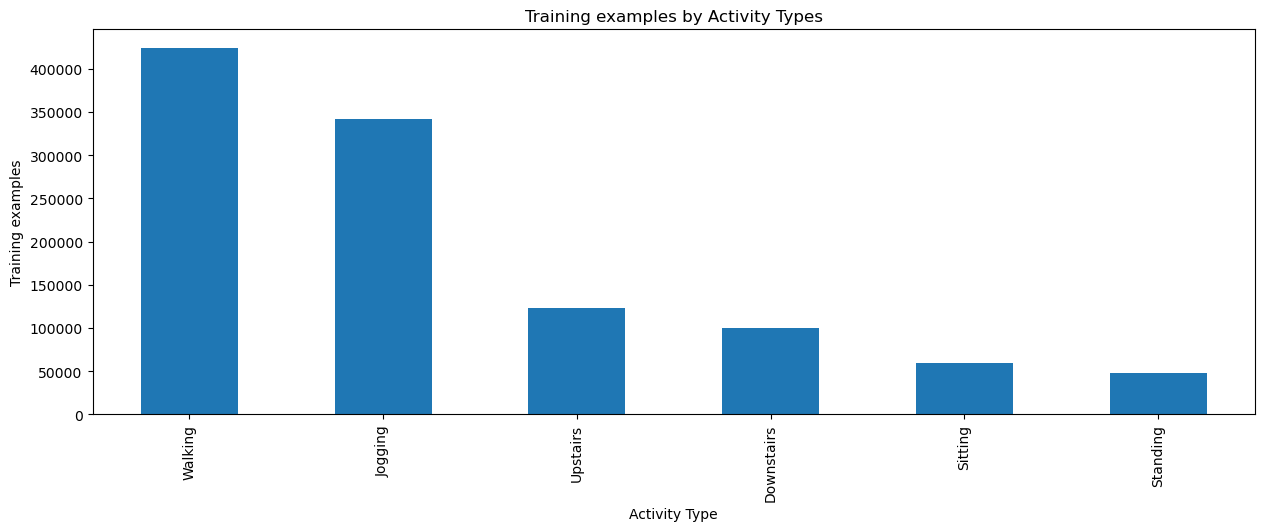

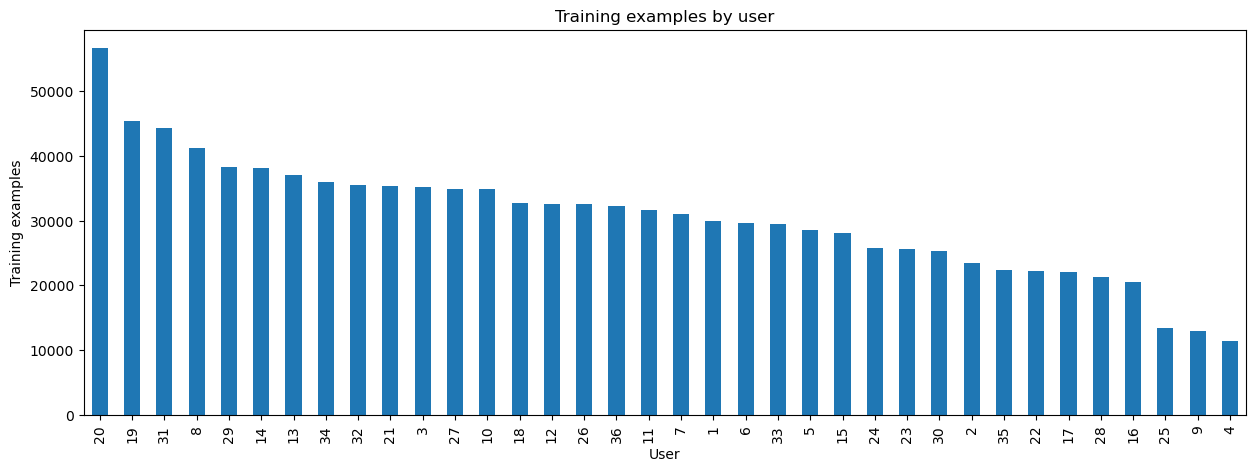

In [275]:
plt.figure(figsize=(15, 5))

plt.xlabel('Activity Type')
plt.ylabel('Training examples')
df['activity'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types')
plt.show()

plt.figure(figsize=(15, 5))
plt.xlabel('User')
plt.ylabel('Training examples')
df['user-id'].value_counts().plot(kind='bar', 
                                 title='Training examples by user')
plt.show()

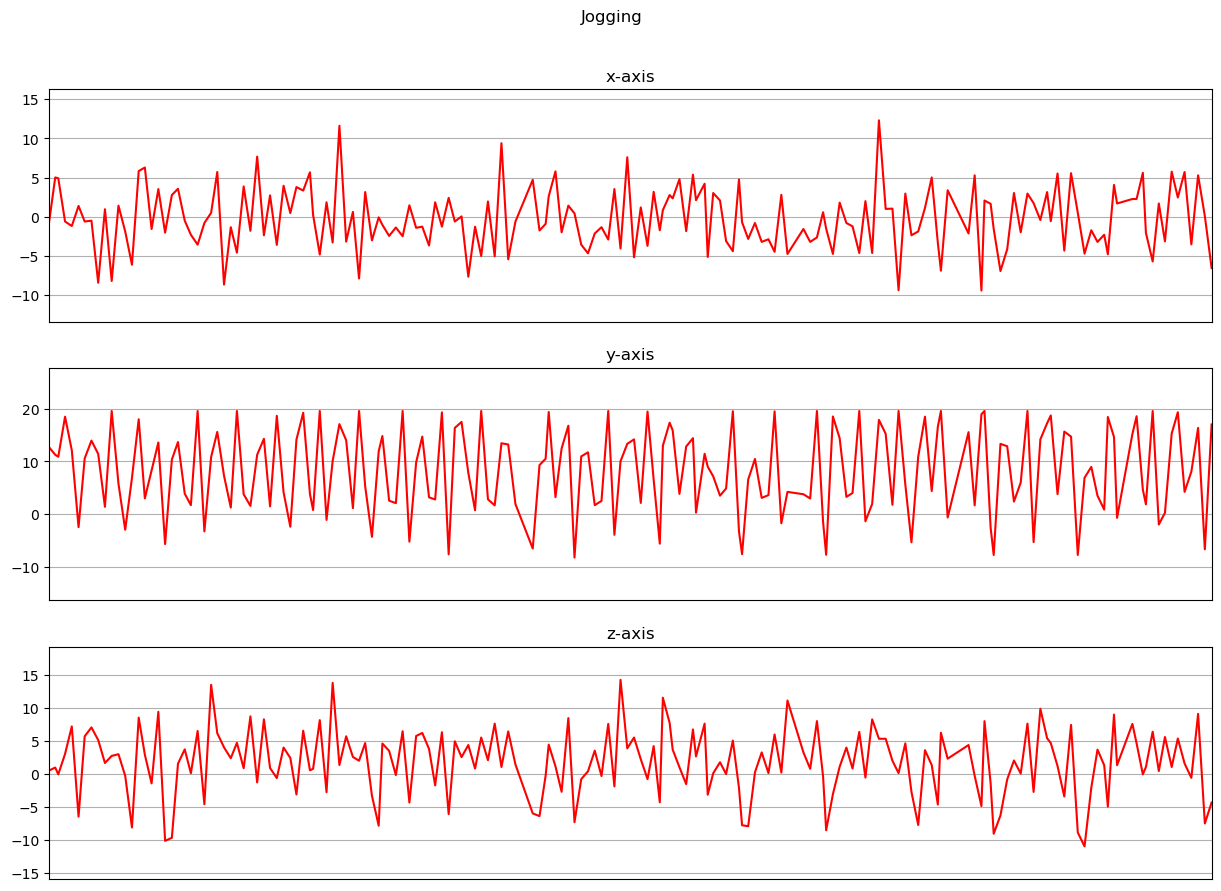

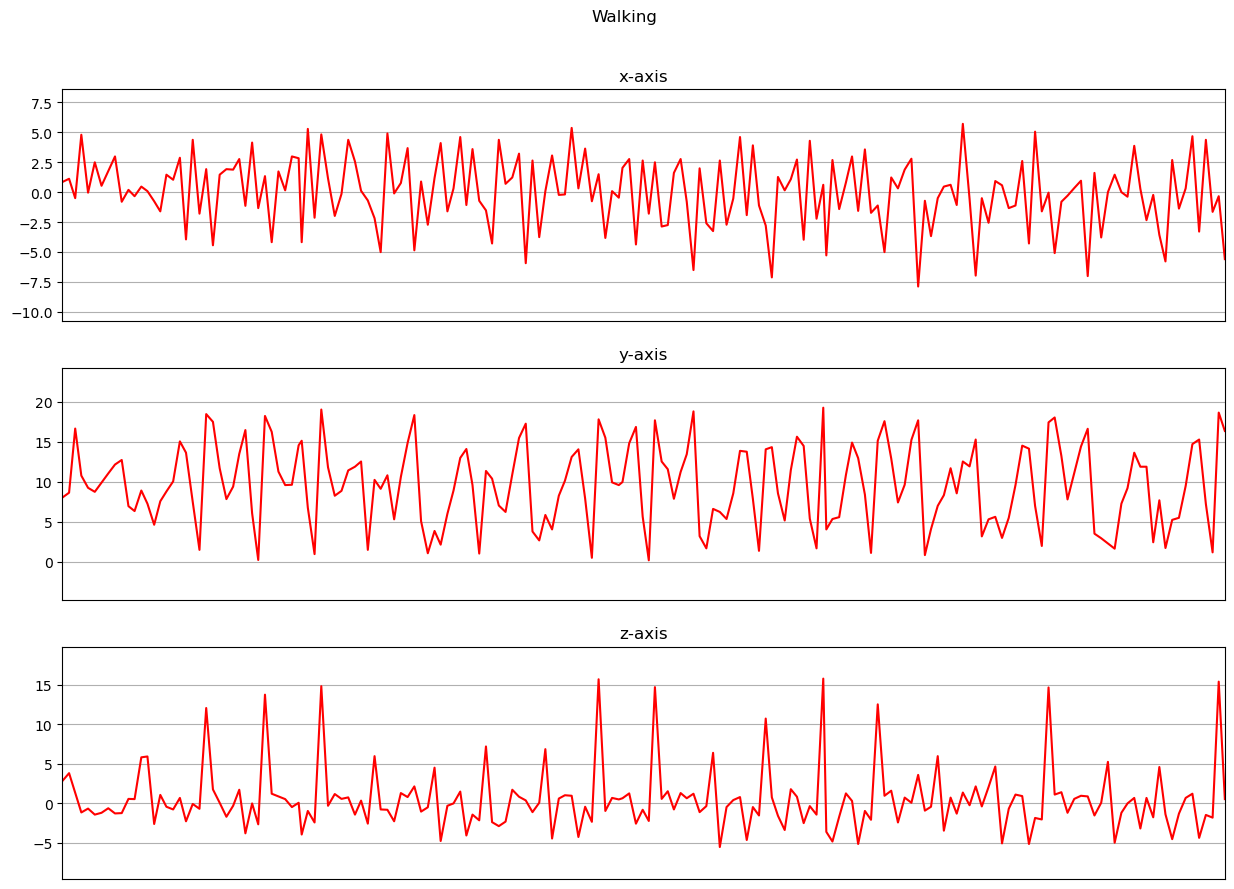

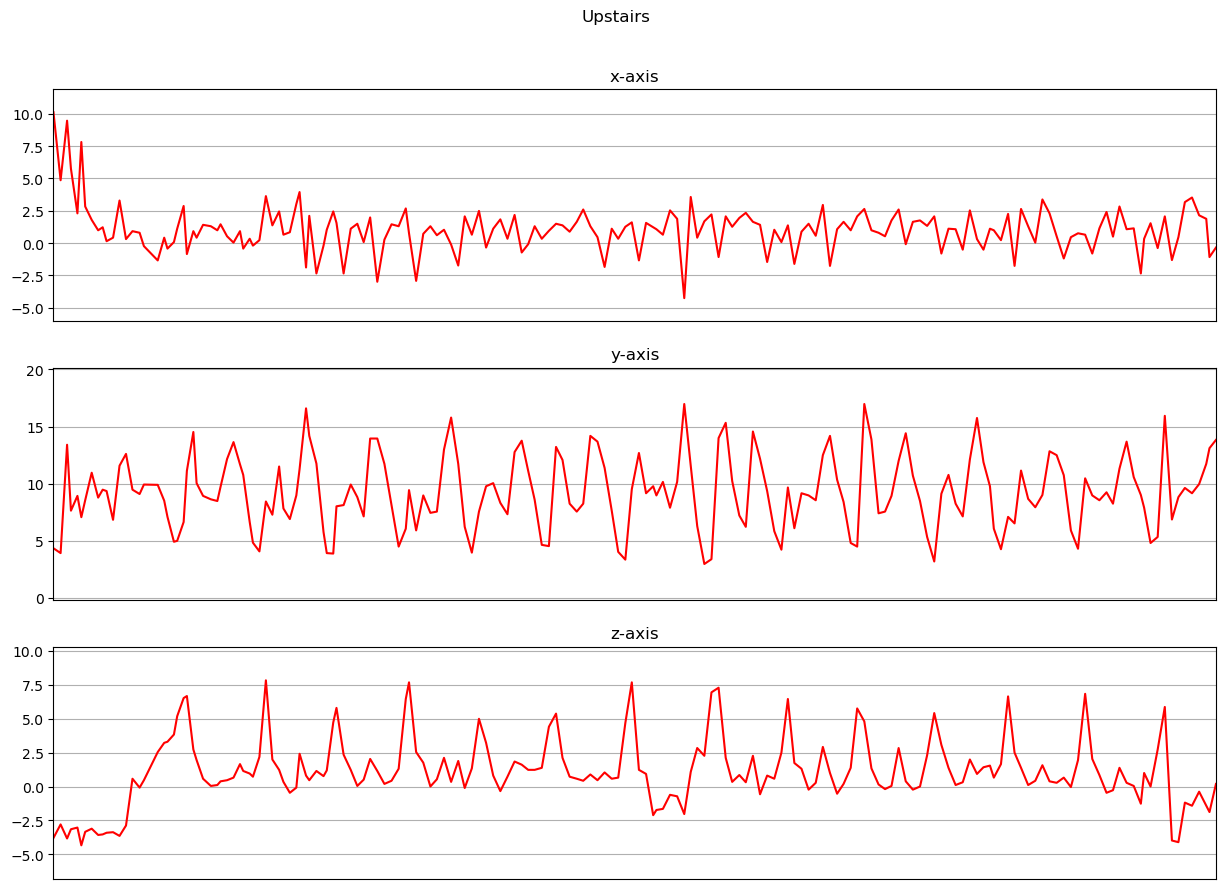

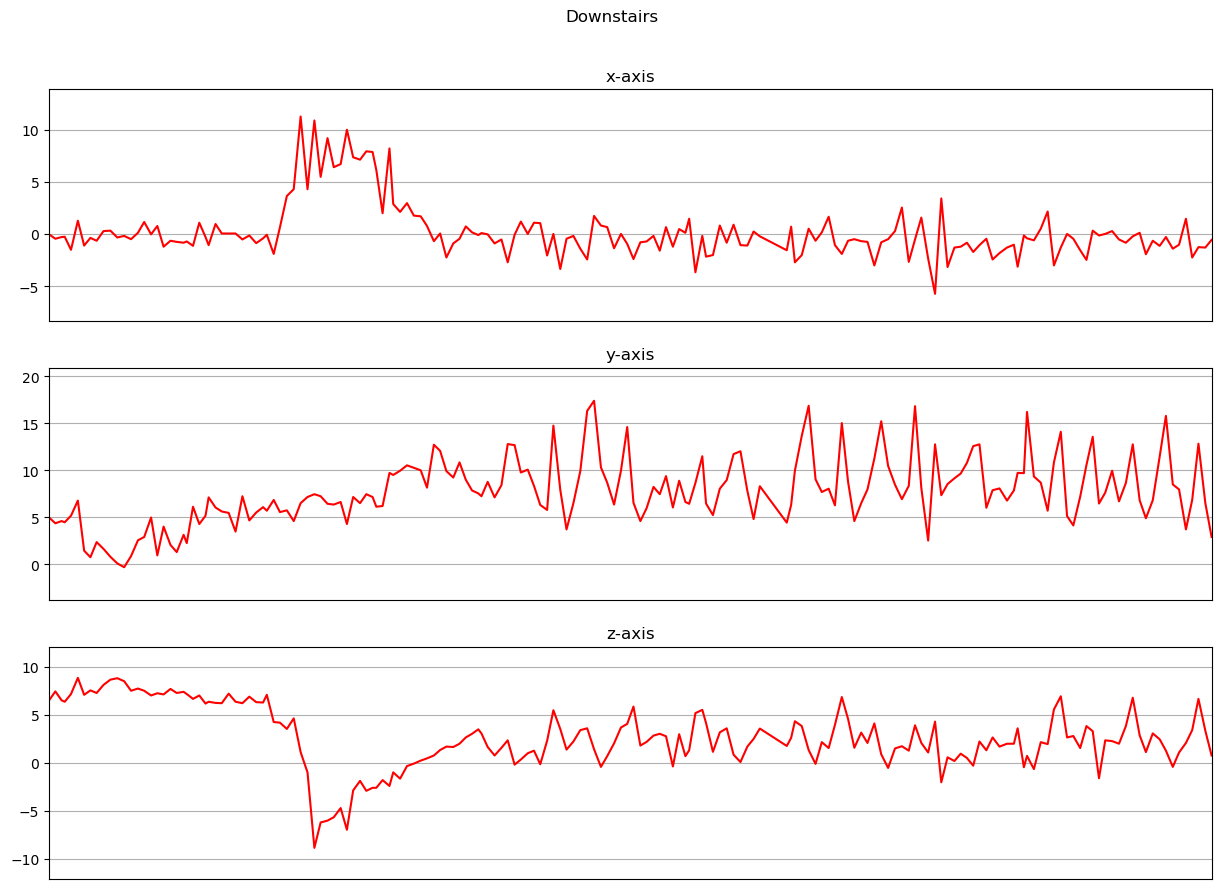

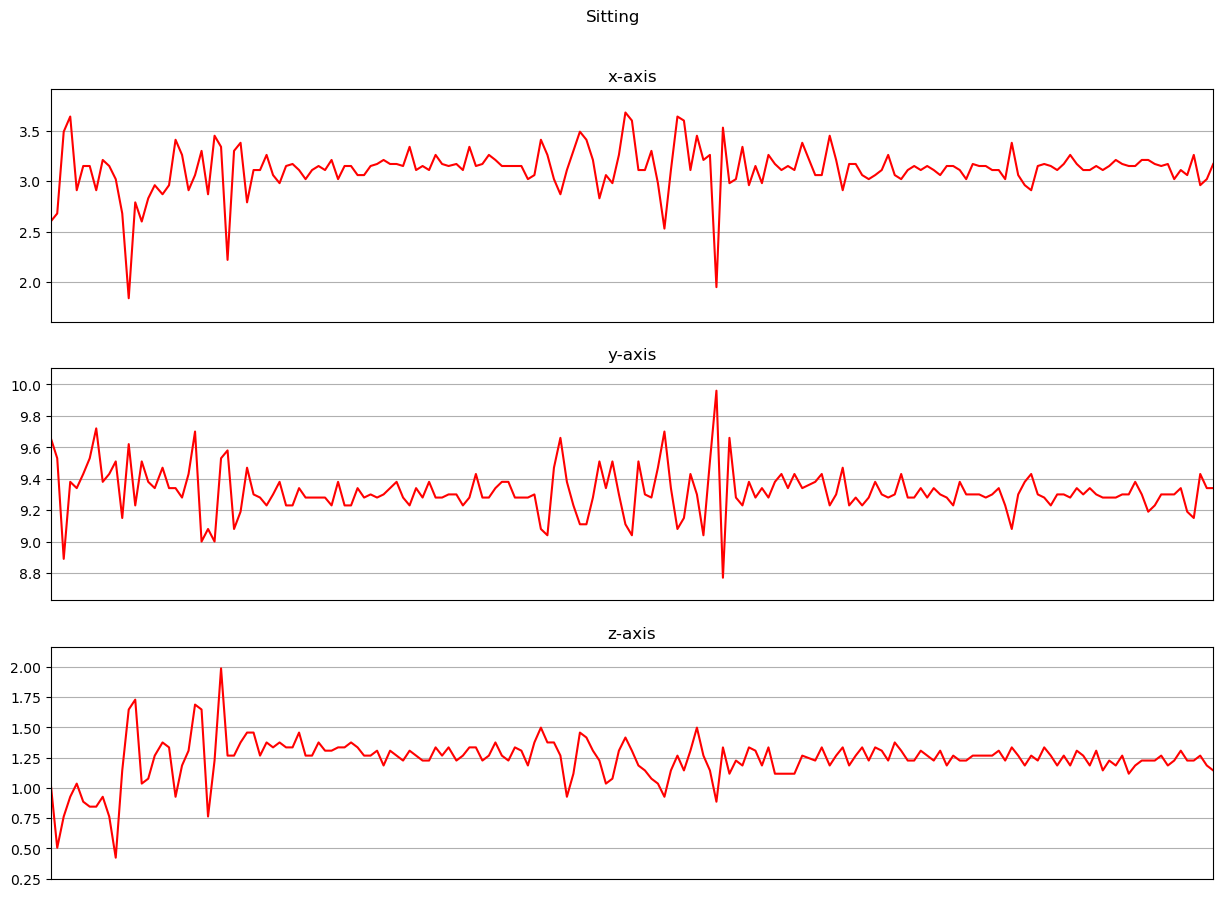

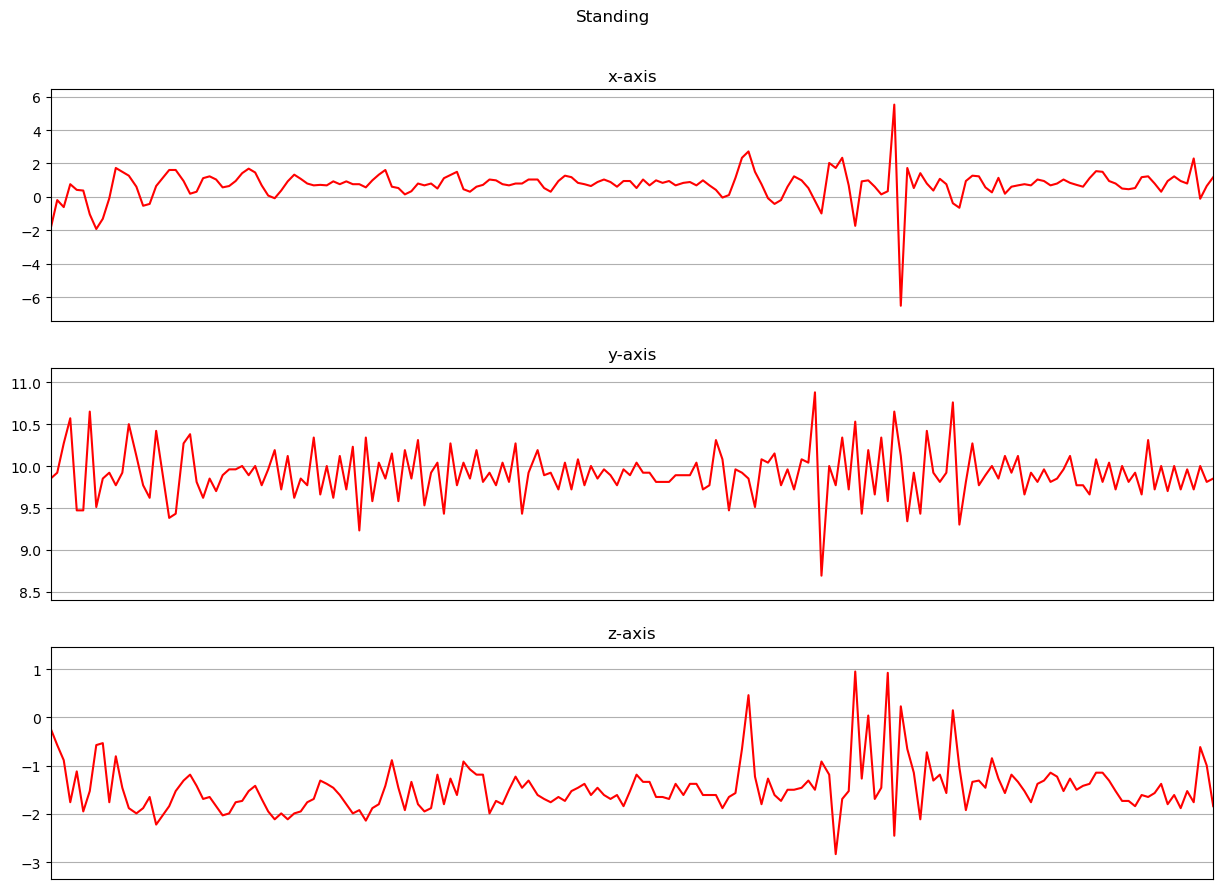

In [276]:
def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
for activity in df['activity'].unique():
    limit = df[df['activity'] == activity][:180]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15, 10))
    axis_plot(ax0, limit['timestamp'], limit['X'], 'x-axis')
    axis_plot(ax1, limit['timestamp'], limit['Y'], 'y-axis')
    axis_plot(ax2, limit['timestamp'], limit['Z'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [277]:
label_encode = LabelEncoder()
df['activityEncode'] = label_encode.fit_transform(df['activity'].values.ravel())
df

,user-id,activity,timestamp,X,Y,Z,activityEncode
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,2
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,2
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,2
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,2


In [278]:
interpolation_fn = interp1d(df['activityEncode'] ,df['Z'], kind='linear')
null_list = df[df['Z'].isnull()].index.tolist()
for i in null_list:
    y = df['activityEncode'][i]
    value = interpolation_fn(y)
    df['Z']=df['Z'].fillna(value)
    print(value)

In [279]:
## train split users between 1 and 27, test split users between 28 and 33
df_test = df[df['user-id'] > 27]
df_train = df[df['user-id'] <= 27]

In [280]:
df_train['X'] = (df_train['X']-df_train['X'].min())/(df_train['X'].max()-df_train['X'].min())
df_train['Y'] = (df_train['Y']-df_train['Y'].min())/(df_train['Y'].max()-df_train['Y'].min())
df_train['Z'] = (df_train['Z']-df_train['Z'].min())/(df_train['Z'].max()-df_train['Z'].min())
df_train

,user-id,activity,timestamp,X,Y,Z,activityEncode
8489,17,Walking,57869902574000,0.510163,0.741908,0.488932,5
8490,17,Walking,57870012316000,0.495703,0.751526,0.487895,5
8491,17,Walking,57870122301000,0.489850,0.742938,0.484785,5
8492,17,Walking,57870222246000,0.499490,0.748778,0.489623,5
8493,17,Walking,57870332292000,0.499490,0.750496,0.486858,5
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,0.723205,0.454981,0.545293,2
1098200,19,Sitting,131623371431000,0.724216,0.457755,0.546308,2
1098201,19,Sitting,131623411592000,0.725228,0.459773,0.545293,2
1098202,19,Sitting,131623491487000,0.723205,0.457755,0.546308,2


In [281]:
def split_sequence(sequence,  time_steps, step):
    X, y = list(), list()
    feature = 3
    for i in range(0, len(sequence) - time_steps, step):
        end_ix = i + time_steps
        if end_ix > len(sequence)-1:
            break
        
        seq_x = sequence[i:end_ix, 3]
        seq_y = sequence[i:end_ix, 4]
        seq_z = sequence[i:end_ix, 5]
        
        values, counts = np.unique(sequence[i:end_ix,6], return_counts=True)
        seq_xyz =  values[np.argmax(counts)]
        
        X.append([seq_x, seq_y, seq_z])
        y.append(seq_xyz)
        
    X = np.asarray(X, dtype=np.float32).reshape(-1, time_steps, feature)
    y = np.asarray(y)
    return array(X), array(y)


time_steps = 160
step=80
df_test = np.array(df_test)
df_train = np.array(df_train)

X_train, y_train = split_sequence(df_train, time_steps, step)
X_test, y_test = split_sequence(df_test, time_steps, step)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((10166, 160, 3), (3558, 160, 3), (10166,), (3558,))

In [282]:
## Input and Output Dimensions
time_period, sensors = X_train.shape[1], X_train.shape[2]
num_classes = label_encode.classes_.size
print(list(label_encode.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [283]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

In [284]:
y_train_hot = to_categorical(y_train, num_classes)
print("y_train shape: ", y_train_hot.shape)

y_test_hot = to_categorical(y_test, num_classes)
print("y_test shape: ", y_train_hot.shape)

y_train shape:  (10166, 6)
y_test shape:  (10166, 6)


In [285]:
# Produce variables for CNN input/output shape
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_hot.shape[1]
print(n_timesteps, n_features, n_outputs)

160 3 6


In [286]:
model = Sequential()
model.add(LSTM(units = 128, input_shape = [n_timesteps, n_features], activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(units = 64, activation = "relu"))
model.add(Dense(n_outputs, activation = "softmax"))

In [287]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               67584     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 76230 (297.77 KB)
Trainable params: 76230 (297.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [288]:
validation_split = 0.1
history = model.fit(X_train, y_train_hot, batch_size= 192, epochs=10, verbose=True,  validation_split=validation_split)

Epoch 1/10
48/48 [==============================] - 47s 869ms/step - loss: 17043128.0000 - accuracy: 0.3765 - val_loss: 1.5711 - val_accuracy: 0.3540
Epoch 2/10
48/48 [==============================] - 40s 835ms/step - loss: 1.5407 - accuracy: 0.3901 - val_loss: 1.4968 - val_accuracy: 0.3540
Epoch 3/10
48/48 [==============================] - 41s 853ms/step - loss: nan - accuracy: 0.3865 - val_loss: nan - val_accuracy: 0.0610
Epoch 4/10
48/48 [==============================] - 37s 761ms/step - loss: nan - accuracy: 0.0915 - val_loss: nan - val_accuracy: 0.0610
Epoch 5/10
48/48 [==============================] - 34s 704ms/step - loss: nan - accuracy: 0.0915 - val_loss: nan - val_accuracy: 0.0610
Epoch 6/10
48/48 [==============================] - 33s 698ms/step - loss: nan - accuracy: 0.0915 - val_loss: nan - val_accuracy: 0.0610
Epoch 7/10
48/48 [==============================] - 34s 701ms/step - loss: nan - accuracy: 0.0915 - val_loss: nan - val_accuracy: 0.0610
Epoch 8/10
48/48 [====

###로스값이 터지는 이유가 뭔지 모르겠습니다.



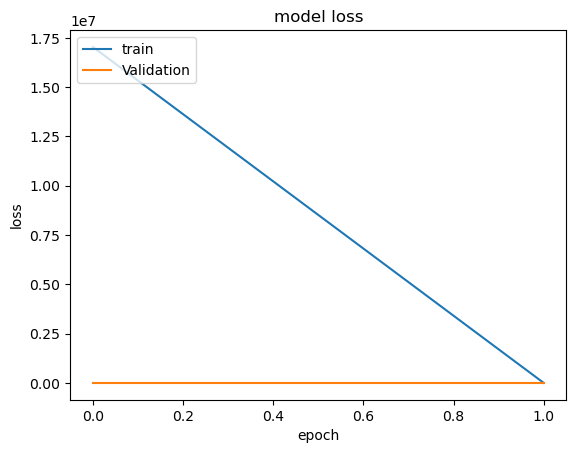

In [289]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

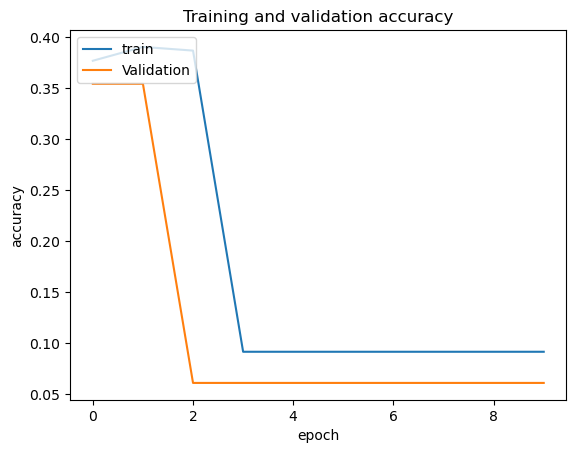

In [290]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [291]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

112/112 [==============================] - 11s 92ms/step
[[ 359    0    0    0    0    0]
 [ 997    0    0    0    0    0]
 [ 227    0    0    0    0    0]
 [ 200    0    0    0    0    0]
 [ 402    0    0    0    0    0]
 [1373    0    0    0    0    0]]
0.10089938167509838
              precision    recall  f1-score   support

           0       0.10      1.00      0.18       359
           1       0.00      0.00      0.00       997
           2       0.00      0.00      0.00       227
           3       0.00      0.00      0.00       200
           4       0.00      0.00      0.00       402
           5       0.00      0.00      0.00      1373

    accuracy                           0.10      3558
   macro avg       0.02      0.17      0.03      3558
weighted avg       0.01      0.10      0.02      3558



<Axes: >

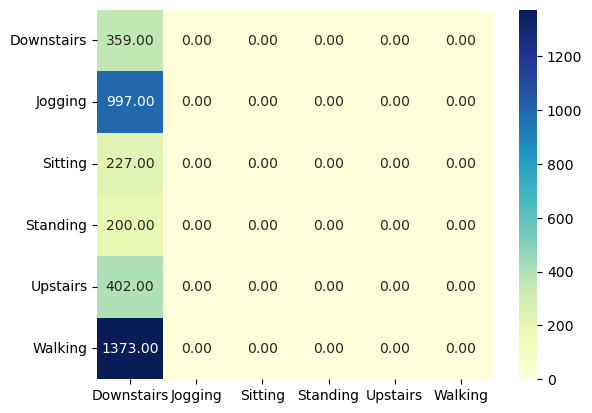

In [292]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sns

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test2 = np.argmax(y_test_hot, axis=-1)

LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
cm=confusion_matrix(y_test2,y_pred)

print(cm)
print(accuracy_score(y_test2,y_pred))
print(classification_report(y_test2,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')